In [27]:
# Import required packages\n",
import os
import numpy as np
import pandas as pd
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
from torch.nn.init import kaiming_uniform
from torchvision.transforms import Resize, ToTensor, Compose
import matplotlib.pyplot as plt
import cv2

In [28]:
# Import the yield data as pandas data frame (Note this is saved as a csv file in base working directory)
file_path = os.path.join(os.getcwd()) + '/train_data/'
# Yield file below has been modified slightly to align the name of the country in the CSV file with that of the numpy array
file_name = 'yield_PR.csv'
yield_data = pd.read_csv(file_path + file_name)

In [29]:
class CustomImageDataset():
    def __init__(self, hist_dir, crop_yield_table, transform=None, target_transform=None):  
        self.hist_dir = hist_dir # References the directory for each given country where the data is stored
        self.transform = transform
        self.target_transform = target_transform
        # load the files 
        filenames = [] # For every year, yields a numpy array of dimension 576 x 46
        crop_yields = []
        for filename in os.listdir(hist_dir):
            if filename != 'yield.csv' and filename != 'yield_PR.csv':
                filenames.append(filename)
                crop_yields.append(crop_yield_table[crop_yield_table['Country Name'] == filename[:-9]][str(int(filename[-8:-4]))].to_numpy())
        self.filenames = filenames
        self.crop_yields = crop_yields
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        hist_dir = os.path.join(self.hist_dir, self.filenames[idx])
        hist = np.load(hist_dir)
       
        # Turn into 3 channel array (triplicate of single layer) --> to function with known model architectures
        hist_3 = np.zeros( ( np.array(hist).shape[0], np.array(hist).shape[1], 3 ) )
        hist_3[:,:,0] = hist # same value in each channel
        hist_3[:,:,1] = hist
        hist_3[:,:,2] = hist
        
        if self.transform:
            hist = self.transform(hist_3).float()
        crop_yield = torch.from_numpy(self.crop_yields[idx].reshape(-1, 1)).float()
        return hist, crop_yield

In [30]:
# Create_Training_Dataset
crop_dataset_train = CustomImageDataset('./train_data/', crop_yield_table = yield_data, transform = Compose([ToTensor(), Resize((224,224))]))

# Create_Training_Dataset
crop_dataset_test = CustomImageDataset('./test_data/', crop_yield_table = yield_data, transform = Compose([ToTensor(), Resize((224,224))]))


In [31]:
crop_dataset_train[3] # Shows for a given tensor which consists of a pair of 1) array of binned histogram data; and 2) yield output

(tensor([[[4.2608e-02, 4.2608e-02, 4.2533e-02,  ..., 4.6571e-02,
           4.6918e-02, 4.6918e-02],
          [2.7705e-01, 2.7705e-01, 2.7678e-01,  ..., 2.3345e-01,
           2.3342e-01, 2.3342e-01],
          [3.8722e-02, 3.8722e-02, 3.9051e-02,  ..., 7.1192e-02,
           7.0520e-02, 7.0520e-02],
          ...,
          [3.9607e-01, 3.9607e-01, 3.9655e-01,  ..., 6.7015e-01,
           6.7240e-01, 6.7240e-01],
          [5.6489e-04, 5.6489e-04, 5.9094e-04,  ..., 2.6951e-03,
           2.7263e-03, 2.7263e-03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[4.2608e-02, 4.2608e-02, 4.2533e-02,  ..., 4.6571e-02,
           4.6918e-02, 4.6918e-02],
          [2.7705e-01, 2.7705e-01, 2.7678e-01,  ..., 2.3345e-01,
           2.3342e-01, 2.3342e-01],
          [3.8722e-02, 3.8722e-02, 3.9051e-02,  ..., 7.1192e-02,
           7.0520e-02, 7.0520e-02],
          ...,
          [3.9607e-01, 3.9607e-01, 3.9655e-01,  ..., 6.701

In [32]:
crop_dataset_train[3][0].shape # For each binned histogram data, consists of 576 observations across 29 dimensions

torch.Size([3, 224, 224])

type of the image:  <class 'torch.Tensor'>
Yield: tensor([[1058.6000]])


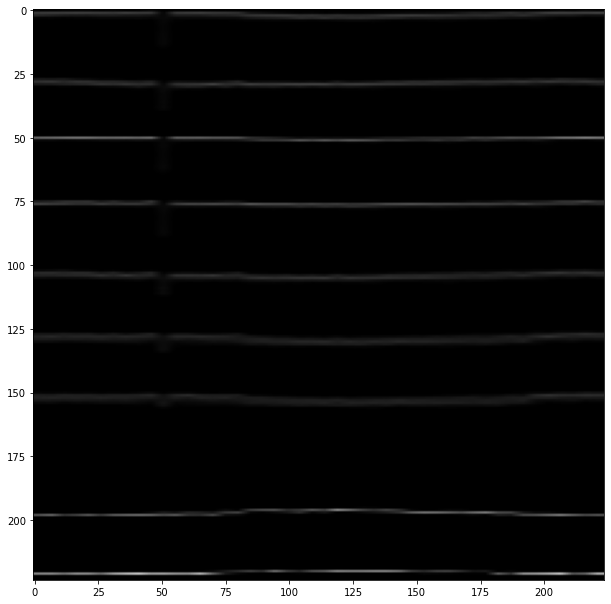

In [33]:
# Plot data for one sample pair
raw_image, crop_yield = crop_dataset_train[0]
figure = plt.figure()
figure.set_size_inches(18.5, 10.5)

print("type of the image: ", type(raw_image))

if type(raw_image) == torch.Tensor:
    plt.imshow(ToPILImage()(raw_image))
else:
    plt.imshow(raw_image)
    
print(f"Yield: {crop_yield}")

In [34]:
# Initialize data loaders
train_dataloader = DataLoader(crop_dataset_train, batch_size=1, shuffle=False)
test_dataloader = DataLoader(crop_dataset_test, batch_size=1, shuffle=False)

In [35]:
# Check device used
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [36]:
# Based on https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [37]:
# Based on https://towardsdev.com/implement-resnet-with-pytorch-a9fb40a77448

class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=1):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input)
        input = self.fc(input)

        return input

In [38]:
# Potentially use pre-trained model as next-step, but not implemented currently
# resnet_model = models.resnet18(pretrained=True).to(device) 

# Don't use pre-trained
model = ResNet18(in_channels = 3, resblock = ResBlock).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
print(model)

# print(model(crop_dataset[3].to(device)))
# optimizer = torch.optim.Adam

ResNet18(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [39]:
# Train model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    correct, train_loss = 0, 0 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
#         print(f"Actual {y}")
#         print(f"Predicted {pred}")

        # Backpropagation
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step() 
    train_loss /= num_batches
    return train_loss 

In [40]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() 
    
    test_val = pd.DataFrame(columns = ['Actual', 'Predicted', 'Error', 'Error_sq', 'Perc_Err'])
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).item()
            pred = model(X).item()                    
            test_val = test_val.append({'Actual' : y, 'Predicted' : pred , 'Error' : abs(pred - y),  'Error_sq': (pred - y)**2, 'Perc_Err' : abs(pred - y) / y}, ignore_index = True)

    return test_val

In [41]:
epochs = 500
train_loss_history = []
test_history_RMSE = []
test_history_MAPE = []

for t in range(epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_vals = test(test_dataloader, model)
    train_loss_history.append(train_loss)
    test_history_RMSE.append(math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count()))
    test_history_MAPE.append(test_vals['Perc_Err'].mean())
    if t%1 == 0:
        print(f"Epoch {t}:")
        print(f"Avg training loss: {train_loss:>8f}")
        print(f"Root Mean Squared Error: {math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count())}")
        print(f"Mean Average Percentage Error: {test_vals['Perc_Err'].mean()}")
print("Done!")

C:\Users\paulr\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:
Avg training loss: 3968662.419271
Root Mean Squared Error: 2037.3982396145398
Mean Average Percentage Error: 0.9731373276454783
Epoch 1:
Avg training loss: 3900916.078225
Root Mean Squared Error: 2019.3132512706381
Mean Average Percentage Error: 0.9523219621647507
Epoch 2:
Avg training loss: 3827890.716302
Root Mean Squared Error: 2000.3841165516399
Mean Average Percentage Error: 0.9304030136095733
Epoch 3:
Avg training loss: 3752559.993924
Root Mean Squared Error: 1980.135490879621
Mean Average Percentage Error: 0.9067051979925017
Epoch 4:
Avg training loss: 3673948.014754
Root Mean Squared Error: 1959.0084384305624
Mean Average Percentage Error: 0.8818267424535726
Epoch 5:
Avg training loss: 3592616.322826
Root Mean Squared Error: 1936.8544419437994
Mean Average Percentage Error: 0.8555187557835475
Epoch 6:
Avg training loss: 3509087.122079
Root Mean Squared Error: 1913.7234847217549
Mean Average Percentage Error: 0.8277283215786396
Epoch 7:
Avg training loss: 3423912.414283

Epoch 60:
Avg training loss: 1346189.940012
Root Mean Squared Error: 1250.8507425072764
Mean Average Percentage Error: 0.46723993554035215
Epoch 61:
Avg training loss: 1333979.806578
Root Mean Squared Error: 1294.7107845069686
Mean Average Percentage Error: 0.46326428986295703
Epoch 62:
Avg training loss: 1330324.439718
Root Mean Squared Error: 1170.7907130770536
Mean Average Percentage Error: 0.4529085620653543
Epoch 63:
Avg training loss: 1320484.944041
Root Mean Squared Error: 1275.0642750198995
Mean Average Percentage Error: 0.471739112928314
Epoch 64:
Avg training loss: 1311812.794240
Root Mean Squared Error: 1274.0494837490994
Mean Average Percentage Error: 0.4584988252737175
Epoch 65:
Avg training loss: 1305681.883444
Root Mean Squared Error: 1251.6658624338224
Mean Average Percentage Error: 0.4442329968277947
Epoch 66:
Avg training loss: 1295050.929543
Root Mean Squared Error: 1221.908517273715
Mean Average Percentage Error: 0.4669213383859372
Epoch 67:
Avg training loss: 12925

Epoch 120:
Avg training loss: 976298.189319
Root Mean Squared Error: 997.1683792215895
Mean Average Percentage Error: 0.41277815946602026
Epoch 121:
Avg training loss: 966468.476002
Root Mean Squared Error: 825.7199068012887
Mean Average Percentage Error: 0.3864190971549447
Epoch 122:
Avg training loss: 959305.233706
Root Mean Squared Error: 1138.9877505321929
Mean Average Percentage Error: 0.4417761397396572
Epoch 123:
Avg training loss: 954672.374353
Root Mean Squared Error: 1267.0102303861627
Mean Average Percentage Error: 0.4960167036861468
Epoch 124:
Avg training loss: 948949.468538
Root Mean Squared Error: 987.9509508537386
Mean Average Percentage Error: 0.43339621823481495
Epoch 125:
Avg training loss: 943439.685827
Root Mean Squared Error: 921.4541759815771
Mean Average Percentage Error: 0.5015826506173224
Epoch 126:
Avg training loss: 937906.553381
Root Mean Squared Error: 1076.4022225866452
Mean Average Percentage Error: 0.438221886188581
Epoch 127:
Avg training loss: 932671.

Epoch 180:
Avg training loss: 657908.062232
Root Mean Squared Error: 1252.7516643922315
Mean Average Percentage Error: 0.511727019386827
Epoch 181:
Avg training loss: 653820.301116
Root Mean Squared Error: 1268.3135808731045
Mean Average Percentage Error: 0.5455819121394524
Epoch 182:
Avg training loss: 649814.856644
Root Mean Squared Error: 1085.4146994525813
Mean Average Percentage Error: 0.5155812818649402
Epoch 183:
Avg training loss: 644844.383901
Root Mean Squared Error: 1306.9874028511506
Mean Average Percentage Error: 0.5113363519362596
Epoch 184:
Avg training loss: 639193.867213
Root Mean Squared Error: 1249.051874518823
Mean Average Percentage Error: 0.5275771189234087
Epoch 185:
Avg training loss: 635436.584820
Root Mean Squared Error: 1252.914629860829
Mean Average Percentage Error: 0.5323632865335651
Epoch 186:
Avg training loss: 630835.773289
Root Mean Squared Error: 1375.4169772987923
Mean Average Percentage Error: 0.5191754583258109
Epoch 187:
Avg training loss: 627786.

Epoch 240:
Avg training loss: 431830.377422
Root Mean Squared Error: 1355.6168533831392
Mean Average Percentage Error: 0.5500856293840146
Epoch 241:
Avg training loss: 429438.987537
Root Mean Squared Error: 1389.5060361357944
Mean Average Percentage Error: 0.5876903219194551
Epoch 242:
Avg training loss: 427140.040252
Root Mean Squared Error: 1430.197518616181
Mean Average Percentage Error: 0.5832365112413771
Epoch 243:
Avg training loss: 424316.539710
Root Mean Squared Error: 1357.231399552721
Mean Average Percentage Error: 0.5928190586879687
Epoch 244:
Avg training loss: 420351.240546
Root Mean Squared Error: 1321.0962041509724
Mean Average Percentage Error: 0.5743977690909858
Epoch 245:
Avg training loss: 418135.406343
Root Mean Squared Error: 1426.32271946207
Mean Average Percentage Error: 0.6011139459295239
Epoch 246:
Avg training loss: 416564.864902
Root Mean Squared Error: 1403.8016931212455
Mean Average Percentage Error: 0.5896867504909983
Epoch 247:
Avg training loss: 412002.1

Epoch 300:
Avg training loss: 272942.223283
Root Mean Squared Error: 1509.950370941243
Mean Average Percentage Error: 0.624071830604776
Epoch 301:
Avg training loss: 271193.084525
Root Mean Squared Error: 1460.1229002245714
Mean Average Percentage Error: 0.5869178772181876
Epoch 302:
Avg training loss: 268041.159751
Root Mean Squared Error: 1501.1613845110996
Mean Average Percentage Error: 0.5925943663585937
Epoch 303:
Avg training loss: 265761.570121
Root Mean Squared Error: 1414.618894157194
Mean Average Percentage Error: 0.5778896563516999
Epoch 304:
Avg training loss: 263775.602343
Root Mean Squared Error: 1477.9402980137
Mean Average Percentage Error: 0.6228444057139642
Epoch 305:
Avg training loss: 262343.673794
Root Mean Squared Error: 1542.6428868332384
Mean Average Percentage Error: 0.6124929845734848
Epoch 306:
Avg training loss: 258912.421387
Root Mean Squared Error: 1408.3403553431135
Mean Average Percentage Error: 0.6033978780248882
Epoch 307:
Avg training loss: 256352.857

Epoch 360:
Avg training loss: 146169.545485
Root Mean Squared Error: 1555.280372659608
Mean Average Percentage Error: 0.6502919352962816
Epoch 361:
Avg training loss: 143254.771560
Root Mean Squared Error: 1612.0393105946955
Mean Average Percentage Error: 0.6799057643299934
Epoch 362:
Avg training loss: 141558.296514
Root Mean Squared Error: 1523.1639455972236
Mean Average Percentage Error: 0.6231438942262707
Epoch 363:
Avg training loss: 140922.653891
Root Mean Squared Error: 1667.6450038900978
Mean Average Percentage Error: 0.6495449209538763
Epoch 364:
Avg training loss: 138323.336325
Root Mean Squared Error: 1637.2480106970756
Mean Average Percentage Error: 0.6677525837309917
Epoch 365:
Avg training loss: 136887.997072
Root Mean Squared Error: 1605.1028358685649
Mean Average Percentage Error: 0.6531054259568727
Epoch 366:
Avg training loss: 135353.221294
Root Mean Squared Error: 1650.2445825423683
Mean Average Percentage Error: 0.6474938535325004
Epoch 367:
Avg training loss: 13312

Epoch 420:
Avg training loss: 65929.489357
Root Mean Squared Error: 1697.2212822152974
Mean Average Percentage Error: 0.683450226799054
Epoch 421:
Avg training loss: 65982.923413
Root Mean Squared Error: 1619.0423683707677
Mean Average Percentage Error: 0.6654364609814516
Epoch 422:
Avg training loss: 65682.910579
Root Mean Squared Error: 1687.389835258514
Mean Average Percentage Error: 0.6774822485510329
Epoch 423:
Avg training loss: 63125.802006
Root Mean Squared Error: 1744.754561216709
Mean Average Percentage Error: 0.7027955029327931
Epoch 424:
Avg training loss: 62859.834904
Root Mean Squared Error: 1681.3615415387078
Mean Average Percentage Error: 0.6883990061564311
Epoch 425:
Avg training loss: 62337.760836
Root Mean Squared Error: 1698.3086211733855
Mean Average Percentage Error: 0.6792339484809607
Epoch 426:
Avg training loss: 60897.045223
Root Mean Squared Error: 1760.0039494245568
Mean Average Percentage Error: 0.7228648147027618
Epoch 427:
Avg training loss: 60437.999752
R

Epoch 480:
Avg training loss: 31998.590305
Root Mean Squared Error: 1760.0640906011217
Mean Average Percentage Error: 0.6809736297078243
Epoch 481:
Avg training loss: 31919.925553
Root Mean Squared Error: 1709.9772340796894
Mean Average Percentage Error: 0.672496505199962
Epoch 482:
Avg training loss: 32780.197484
Root Mean Squared Error: 1752.5509889354478
Mean Average Percentage Error: 0.7300709406705116
Epoch 483:
Avg training loss: 30854.480291
Root Mean Squared Error: 1746.7944618990246
Mean Average Percentage Error: 0.7026381892531156
Epoch 484:
Avg training loss: 30869.410873
Root Mean Squared Error: 1739.9983973438323
Mean Average Percentage Error: 0.7097566092420449
Epoch 485:
Avg training loss: 31624.217438
Root Mean Squared Error: 1678.8396762876148
Mean Average Percentage Error: 0.6834204635323329
Epoch 486:
Avg training loss: 30432.571229
Root Mean Squared Error: 1715.7391772282215
Mean Average Percentage Error: 0.6954709033077431
Epoch 487:
Avg training loss: 30336.924656

In [42]:
# Save model state
model_path = os.path.join(os.getcwd(), 'model')
print(model_path)

torch.save(model.state_dict(), model_path + '\CNN_model_state.model')

C:\Users\paulr\GitHub\MSBD-5001-Group-Project\NN+CNN\model


In [43]:
# Load model state
model_path = os.path.join(os.getcwd(), 'model')
model.load_state_dict(torch.load(model_path + '\CNN_model_state.model'))

<All keys matched successfully>

In [44]:
print(train_loss_history)

[3968662.4192708335, 3900916.0782251605, 3827890.716301638, 3752559.993923611, 3673948.014754162, 3592616.3228262444, 3509087.122079007, 3423912.414282747, 3337669.4558764077, 3250848.2767012566, 3164113.7879668395, 3077923.3987689554, 2992931.563988219, 2909517.026316243, 2828208.664449791, 2749314.992875815, 2673426.4538669204, 2600884.326985459, 2520129.433849383, 2431411.0472218986, 2368111.87269075, 2309594.639132404, 2255965.82384748, 2206118.4978629355, 2159947.9960044688, 2116946.8560150666, 2078298.5870020885, 2040143.9062538052, 2016167.2186420255, 1969783.6351398402, 1933599.5671183865, 1892232.928508427, 1860033.8733637666, 1822471.2298904501, 1786776.103493559, 1757408.2835547924, 1721780.344076968, 1690755.291275947, 1670611.3052605584, 1653222.6975038317, 1631937.4496397034, 1604458.2867993803, 1591736.7323490425, 1572387.990364129, 1557234.9685177926, 1532957.005596332, 1513127.3104184114, 1497869.4515660948, 1486333.4873289831, 1464526.6739011179, 1452713.4580355755, 1

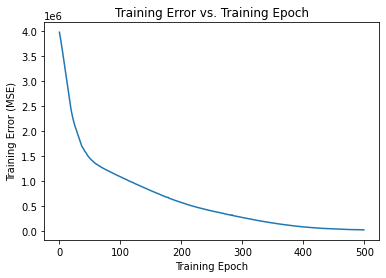

In [45]:
# Plot Training Error
plt.plot(train_loss_history)
plt.title('Training Error vs. Training Epoch')
plt.ylabel('Training Error (MSE)')
plt.xlabel('Training Epoch')
plt.show()

[Text(0, 0.5, 'Testing Mean Average Percentage Error'),
 Text(0.5, 0, 'Training Epoch')]

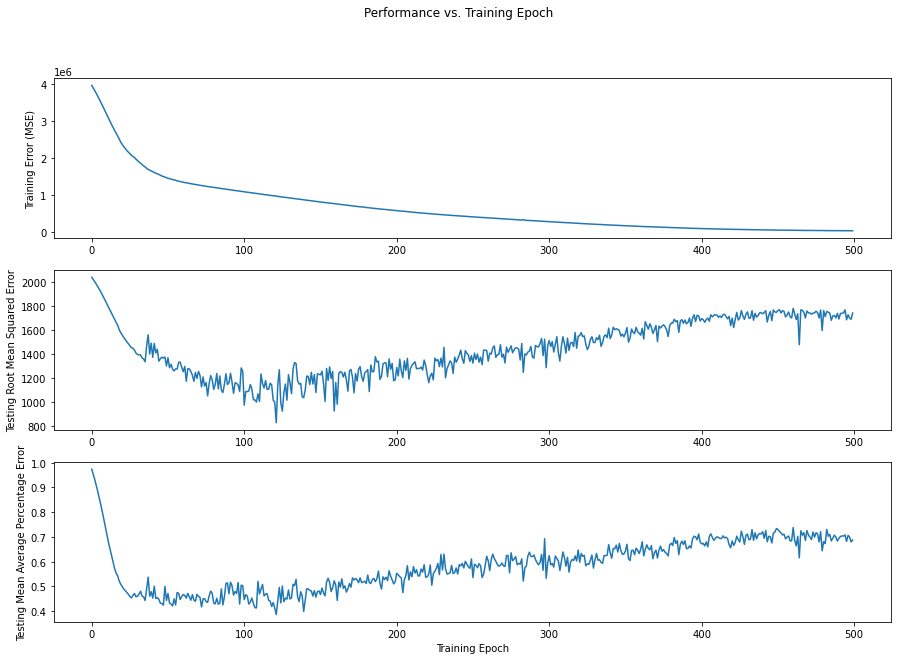

In [46]:
# Plot training error, and testing results
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_figheight(10)
fig.set_figwidth(15)
fig.suptitle('Performance vs. Training Epoch')
ax1.plot(train_loss_history)
ax2.plot(test_history_RMSE)
ax3.plot(test_history_MAPE)
ax1.set(ylabel = 'Training Error (MSE)')
ax2.set(ylabel ='Testing Root Mean Squared Error')
ax3.set(ylabel ='Testing Mean Average Percentage Error', xlabel ='Training Epoch')

In [47]:
# Now to make predictions and evaluate model
test_vals = test(test_dataloader, model)
print(f"Root Mean Squared Error: {math.sqrt(test_vals['Error_sq'].sum() / test_vals['Error_sq'].count())}")
print(f"Mean Average Percentage Error: {test_vals['Perc_Err'].mean()}")

Root Mean Squared Error: 1740.1595452962747
Mean Average Percentage Error: 0.687455883108875


In [48]:
test_vals

,Actual,Predicted,Error,Error_sq,Perc_Err
0,1400.199951,551.759338,848.440613,7.198515e+05,0.605942
1,982.500000,395.813782,586.686218,3.442007e+05,0.597136
2,1336.699951,478.163849,858.536102,7.370842e+05,0.642280
3,940.500000,473.864777,466.635223,2.177484e+05,0.496157
4,1168.900024,502.797760,666.102264,4.436922e+05,0.569854
5,801.900024,271.999908,529.900116,2.807941e+05,0.660806
6,768.700012,45.257607,723.442406,5.233689e+05,0.941124
7,7117.200195,469.084961,6648.115234,4.419744e+07,0.934091
8,1595.400024,45.257607,1550.142418,2.402942e+06,0.971632
9,1830.300049,414.318542,1415.981506,2.005004e+06,0.773634
